In [209]:
from sklearn.datasets import make_blobs, make_moons
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import collections
import scipy
import time
import math

In [210]:
FROM_DATASET = True
N_SAMPLES = 10000
PARTITION = int(N_SAMPLES*0.1)
ITERS = 60
EPSILON = 1e-5

#diabetes, smoking, Surgical-deepnet.csv
DATABASE = 'Surgical-deepnet'

In [211]:

if not FROM_DATASET:
    # Set random seed for reproducibility
    np.random.seed(420)

    # Create dataset with 10,000 points and 2 clusters
    #X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=420)
    y = np.where(y == 0, -1, y)

    # Print the shapes of X and y
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Create scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Add axis labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

    # Show the plot
    plt.show()

else:

    if DATABASE == "diabetes":
        data = np.genfromtxt('diabetes.csv', delimiter=',', skip_header=1)
        X = data[:, :-1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)
    
    if DATABASE == "smoking":
        data = np.genfromtxt('smoking.csv', delimiter=',', skip_header=1)
        X = data[:, : -1]
        y = data[:, -1]

        columns_to_remove = [0, 1, 23, 25]
        X = np.delete(X, columns_to_remove, axis=1) 
        X = X[:10000]
        y = np.where(y == 0, -1, y)
        y = y[:10000]

    if DATABASE == "Surgical-deepnet":
        data = np.genfromtxt('Surgical-deepnet.csv', delimiter=',', skip_header=1)
        X = data[:, : -1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)


In [212]:
print("Dataset Lenght")
print("Tot: " + str(len(X)) + ", lab: " + str(PARTITION) + ", unlab: " + str(len(X)-PARTITION))

X.shape

Dataset Lenght
Tot: 14635, lab: 1000, unlab: 13635


(14635, 24)

In [213]:

# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

# Label initialization
labeled_y = np.array(y[:PARTITION])
target_y = np.array(y[PARTITION:])
initial_y = np.random.choice([-1,1], size = (len(unlabeled_X,)))

In [214]:
# Check y
print("Target: " + str(len(y_unlabeled_target)))
print("Initial: " + str(len(y_unlabeled_initial)))

Target: 348
Initial: 348


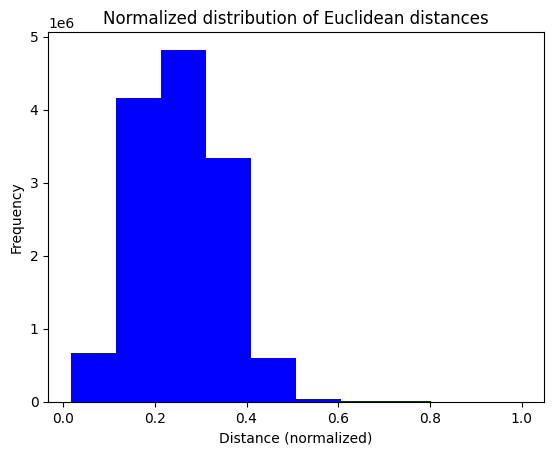

In [215]:

# Calculate distances
labeled_distances = cdist(labeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

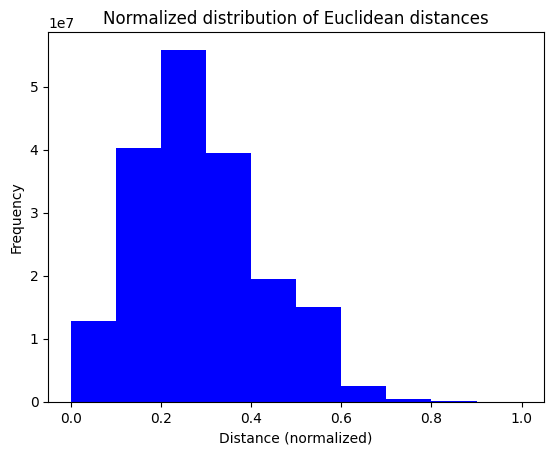

In [216]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()


In [217]:
if not FROM_DATASET:
    plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
    plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=labeled_y)
    plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-10 ||a-b||^2_2}
$$

In [218]:
def weight(dist):
    return math.e**(-10*dist**2)

In [219]:
%%time
print("Computing weights")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_normalized_distances)
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_normalized_distances)
print('Done')

Computing weights
Done
CPU times: user 1min, sys: 26.7 s, total: 1min 27s
Wall time: 4min 14s


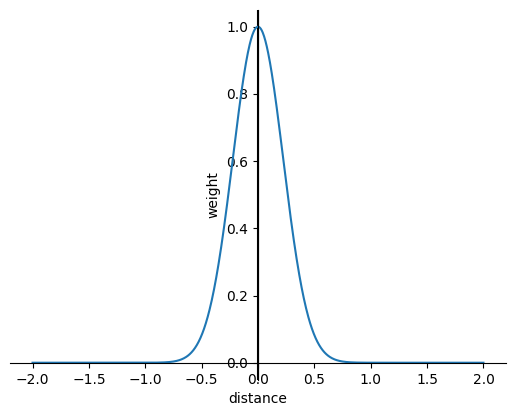

In [220]:
X = np.linspace(-2, 2, 1000)
plt.figure(dpi=100)
ax = plt.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight(d) for d in X], label="asd")

The following are two implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the following function is using linear algebra and Numpy to calcolate it, in order to have decent performance

In [221]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * labeled_unlabeled_weights.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * unlabeled_unlabeled_weights.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [222]:
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            target_y
        )
    ) / len(target_y)

def accuracy(current):
    return accuracy_round(current) #loss(labeled_y, current)

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:
$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &=\bar{w}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2(\sum_{i=0}^lw_{ij}) + (\sum_{i=0}^u\bar{w}_{ij}) - \bar{w}_{jj} \\
\end{align*}
\\
\[
  Hessian_{n\times n} =
  \left[ {\begin{array}{cccc}
    2(\sum_{i=0}^lw_{i1}) + (\sum_{i=0}^u\bar{w}_{i1}) - \bar{w}_{11} & -\bar{w}_{12} & \cdots & -\bar{w}_{1n}\\
    -\bar{w}_{21} & 2(\sum_{i=0}^lw_{i2}) + (\sum_{i=0}^u\bar{w}_{i2}) - \bar{w}_{22} & \cdots & -\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{w}_{n1} & -\bar{w}_{n2} & \cdots & 2(\sum_{i=0}^lw_{in}) + (\sum_{i=0}^u\bar{w}_{in}) - \bar{w}_{nn}\\
  \end{array} } \right]
\]

$$


### Hessian and constants

In [223]:
%%time
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(target_y)):
        mat[i][i] = 2 * np.sum(labeled_unlabeled_weights[:,i]) + np.sum(unlabeled_unlabeled_weights[:,i]) - unlabeled_unlabeled_weights[i][i]
    print()
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

print("Calculating the Hessian matrix")
hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)
print("Calculating sigma (strongly convex)")
sigma = estimate_degree_strongly_convex(hessian)
strongly_convex = sigma > 0
print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
print("Estimating Lipschitz constant for the whole function")
L = estimate_lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")


Calculating the Hessian matrix

Calculating sigma (strongly convex)
Sigma: 265.0606650698661,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 10290.361693610745
CPU times: user 18min 52s, sys: 3min 59s, total: 22min 52s
Wall time: 5min 31s


Following are some constant that are going to be used in the gradient, since it can rewritten in a format which allows to avoid having to redo those calculation each time

In [224]:
print("Calculating coefficients of the gradient")
sum_row_label_unlabel = np.sum(labeled_unlabeled_weights, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(unlabeled_unlabeled_weights, axis=0).reshape((-1,1))
grad_first_coeff_vec = (2 * sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = 2 * np.multiply(
    labeled_y.reshape((-1,1)),
    labeled_unlabeled_weights
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [225]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.multiply(
        unlabeled,
        unlabeled_unlabeled_weights
    ).sum(0).reshape((-1,1))
    return (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [226]:
y_unlabeled_gd = np.copy(initial_y)

In [227]:
%%time
ticks_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(labeled_y, y_unlabeled_gd)]
init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(labeled_y, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(labeled_y, y_unlabeled_gd)}
""")

00% - iter 0 / 60 - final accuracy 51.29% - loss 12647800.76
10% - iter 6 / 60 - final accuracy 72.86% - loss 1691464.22


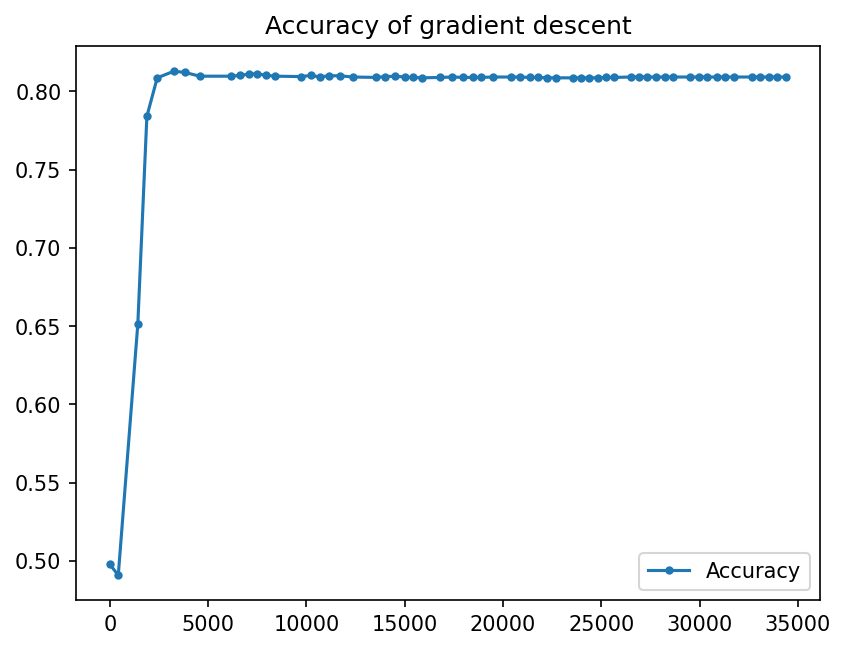

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of gradient descent")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm with use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [ ]:
y_unlabeled_gd_improved = np.copy(initial_y)

In [ ]:
%%time
ticks_gd_improved = [0]
accuracies_gd_improved = [accuracy(y_unlabeled_gd_improved)]
losses_gd_improved = [loss(labeled_y, y_unlabeled_gd_improved)]
init_time = time.time() * 1000
for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_improved)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 if strongly_convex else 1)/(L + (sigma if strongly_convex else 0)) * grad
    accuracies_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    losses_gd_improved.append(loss(labeled_y, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd_improved[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd_improved):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(labeled_y, y_unlabeled_gd_improved)}
""")

00% - iter 0 / 60 - final accuracy 56.27% - loss 2297948.71
10% - iter 6 / 60 - final accuracy 82.49% - loss 697002.79
20% - iter 12 / 60 - final accuracy 80.77% - loss 685406.47
30% - iter 18 / 60 - final accuracy 80.95% - loss 685165.60
40% - iter 24 / 60 - final accuracy 80.95% - loss 685158.85
50% - iter 30 / 60 - final accuracy 80.93% - loss 685158.62
60% - iter 36 / 60 - final accuracy 80.93% - loss 685158.61
70% - iter 42 / 60 - final accuracy 80.93% - loss 685158.61
80% - iter 48 / 60 - final accuracy 80.93% - loss 685158.61
90% - iter 54 / 60 - final accuracy 80.93% - loss 685158.61

Final accuracy: 80.93%
Norm gradient: 0.0015208222348700219
Loss: 685158.6121494548

CPU times: user 30.3 s, sys: 763 ms, total: 31.1 s
Wall time: 31.8 s


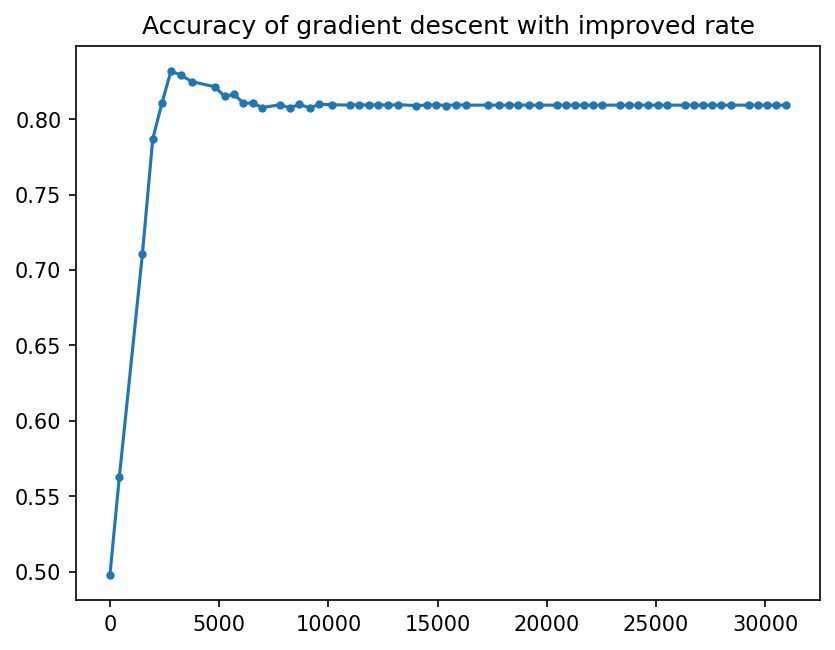

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of gradient descent with improved rate")
plt.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')

### Heavy ball

In [ ]:
y_unlabeled_gd_hb_previous = y_unlabeled_gd_hb = np.copy(initial_y)

In [ ]:
%%time
ticks_gd_hb = [0]
accuracies_gd_hb = [accuracy(y_unlabeled_gd_hb)]
losses_gd_hb = [loss(labeled_y, y_unlabeled_gd_hb)]
init_time = time.time() * 1000
Alpha = 1
for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_hb)
    if EPSILON >= np.linalg.norm(grad):
        break

    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    momentum = Beta * (y_unlabeled_gd_hb - y_unlabeled_gd_hb_previous)

    old_y_unlabeled_gd_hb = np.copy(y_unlabeled_gd_hb)
    y_unlabeled_gd_hb = y_unlabeled_gd_hb - 1/L * grad + momentum
    y_unlabeled_gd_hb_previous = old_y_unlabeled_gd_hb

    accuracies_gd_hb.append(accuracy(y_unlabeled_gd_hb))
    losses_gd_hb.append(loss(labeled_y, y_unlabeled_gd_hb))
    ticks_gd_hb.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd_hb[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd_hb):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_hb[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_hb))}
Loss: {loss(labeled_y, y_unlabeled_gd_hb)}
""")

00% - iter 0 / 60 - final accuracy 49.07% - loss 1133068.23
10% - iter 6 / 60 - final accuracy 80.93% - loss 710099.13
20% - iter 12 / 60 - final accuracy 81.24% - loss 690588.66
30% - iter 18 / 60 - final accuracy 80.77% - loss 687636.32
40% - iter 24 / 60 - final accuracy 80.53% - loss 686533.84
50% - iter 30 / 60 - final accuracy 80.77% - loss 685594.72
60% - iter 36 / 60 - final accuracy 80.82% - loss 685843.50
70% - iter 42 / 60 - final accuracy 80.79% - loss 685211.26
80% - iter 48 / 60 - final accuracy 80.87% - loss 685525.89
90% - iter 54 / 60 - final accuracy 80.82% - loss 685206.38

Final accuracy: 80.87%
Norm gradient: 493.2195551109098
Loss: 685355.2665728809

CPU times: user 30.3 s, sys: 670 ms, total: 31 s
Wall time: 31.5 s


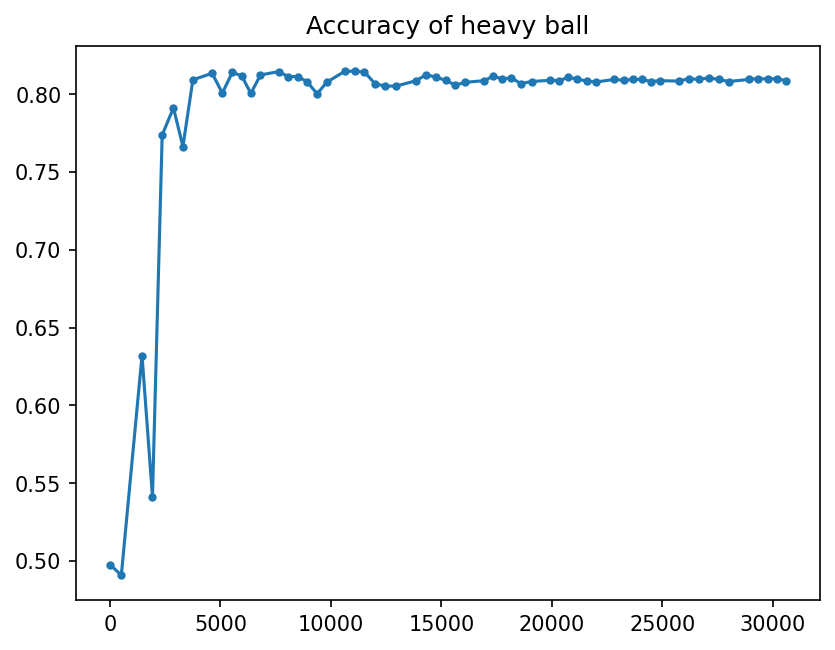

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of heavy ball")
plt.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')

### Accelerated Gradient

In [ ]:
y_unlabeled_gd_accelerated_previous = y_unlabeled_gd_accelerated = np.copy(initial_y)

In [ ]:
%%time
ticks_gd_accelerated = [0]
accuracies_gd_accelerated = [accuracy(y_unlabeled_gd_accelerated)]
init_time = time.time() * 1000
losses_gd_accelerated = [loss(labeled_y, y_unlabeled_gd_accelerated)]
Alpha = 1
for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    new_position = y_unlabeled_gd_accelerated + Beta * (y_unlabeled_gd_accelerated - y_unlabeled_gd_accelerated_previous)
    grad = gradient(new_position)
    if EPSILON >= np.linalg.norm(grad):
        break

    old_y_unlabeled_gd_accelerated = np.copy(y_unlabeled_gd_accelerated)
    y_unlabeled_gd_accelerated = new_position - 1/L * grad
    y_unlabeled_gd_accelerated_previous = old_y_unlabeled_gd_accelerated

    accuracies_gd_accelerated.append(accuracy(y_unlabeled_gd_accelerated))
    losses_gd_accelerated.append(loss(labeled_y, y_unlabeled_gd_accelerated))
    ticks_gd_accelerated.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd_accelerated[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd_accelerated):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_accelerated[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_accelerated))}
Loss: {loss(labeled_y, y_unlabeled_gd_accelerated)}
""")

00% - iter 0 / 60 - final accuracy 49.07% - loss 1133068.23
10% - iter 6 / 60 - final accuracy 80.87% - loss 686422.42
20% - iter 12 / 60 - final accuracy 80.98% - loss 685011.76
30% - iter 18 / 60 - final accuracy 80.90% - loss 685181.41
40% - iter 24 / 60 - final accuracy 80.93% - loss 685155.75
50% - iter 30 / 60 - final accuracy 80.93% - loss 685158.76
60% - iter 36 / 60 - final accuracy 80.90% - loss 685158.71
70% - iter 42 / 60 - final accuracy 80.93% - loss 685158.56
80% - iter 48 / 60 - final accuracy 80.93% - loss 685158.63
90% - iter 54 / 60 - final accuracy 80.93% - loss 685158.61

Final accuracy: 80.93%
Norm gradient: 0.033151575132418336
Loss: 685158.6137399747

CPU times: user 31.9 s, sys: 1.66 s, total: 33.5 s
Wall time: 36.6 s


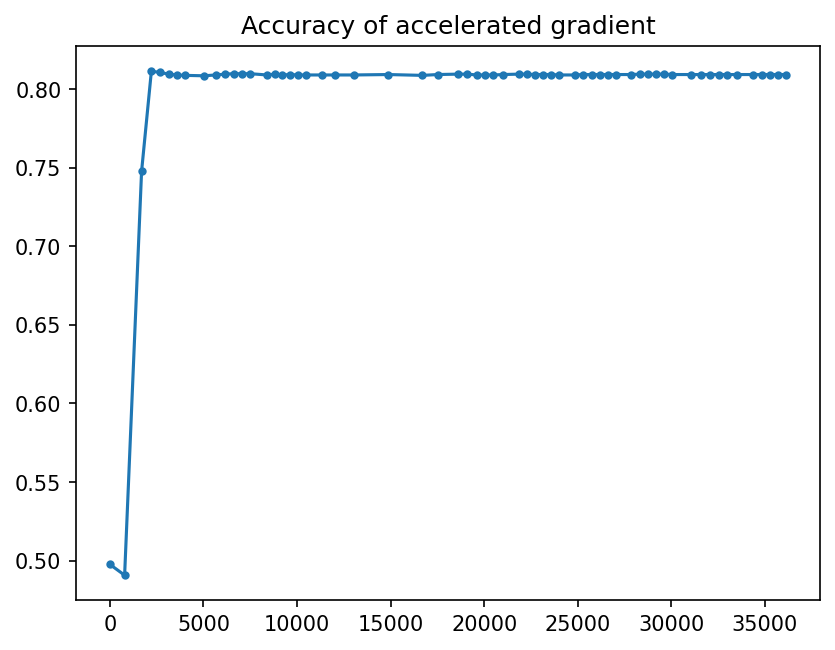

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of accelerated gradient")
plt.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [ ]:
def derivative(unlabeled, j):
    return grad_first_coeff_vec[j] * unlabeled[j] - \
           grad_second_coeff_vec[j] - \
           np.matmul(w_unlabeled_unlabeled[:,j], unlabeled.T)

def derivative_iterative(labeled, unlabeled, j):
    tot = 0
    for i in range(len(labeled)):
        tot += 2*w_labeled_unlabeled[i][j] * (unlabeled[j] - labeled[i])
    for i in range(len(unlabeled)):
        tot += w_unlabeled_unlabeled[i][j] * (unlabeled[j] - unlabeled[i])
    return tot

def update_gradient(previous_grad, Li, index):
    global unlabeled_unlabeled_weights, grad_first_coeff_vec
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += unlabeled_unlabeled_weights[index] * step
    new_grad[index] -= grad_first_coeff_vec[index] * step
    return step, new_grad

### Randomized

In [ ]:
y_unlabeled_bcgd_random = np.copy(initial_y).astype("float64")

In [ ]:
%%time
ticks_bcgd_random= [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(labeled_y, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(target_y) == 0:

        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(labeled_y, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_random[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_random)}
""")

00% - iter 0 / 226800

IndexError: index 661 is out of bounds for axis 0 with size 348

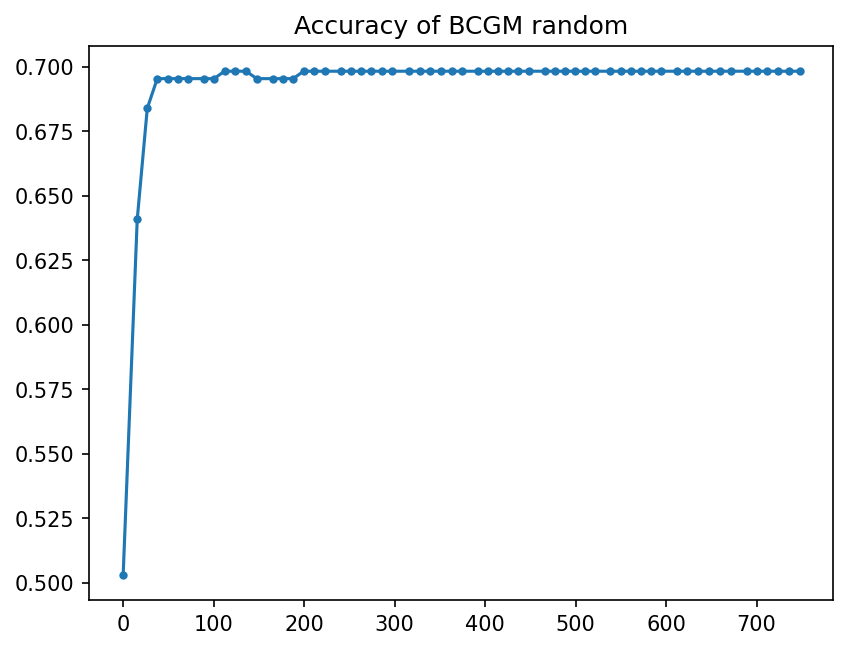

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of BCGM random")
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')

### Cyclic

In [ ]:
y_unlabeled_bcgd_cyclic = np.copy(initial_y).astype("float64")

In [ ]:
%%time
ticks_bcgd_cyclic= [0]
accuracies_bcgd_cyclic= [accuracy(y_unlabeled_bcgd_cyclic)]
losses_bcgm_cyclic = [loss(labeled_y, y_unlabeled_bcgd_cyclic)]

previous_grad_cyclic = gradient(y_unlabeled_bcgd_cyclic)
max_iterations = ITERS*len(y_unlabeled_bcgd_cyclic)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = i % len(y_unlabeled_bcgd_cyclic)

    step, new_grad = update_gradient(previous_grad_cyclic, Li, index)
    y_unlabeled_bcgd_cyclic[index] = y_unlabeled_bcgd_cyclic[index] - step
    previous_grad_cyclic = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_cyclic):
        break

    if (i+1) % len(target_y) == 0:

        accuracies_bcgd_cyclic.append(accuracy(y_unlabeled_bcgd_cyclic))
        losses_bcgm_cyclic.append(loss(labeled_y, y_unlabeled_bcgd_cyclic))
        ticks_bcgd_cyclic.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_cyclic[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_cyclic):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_cyclic[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_cyclic))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_cyclic)}
""")

00% - iter 0 / 20880 - final accuracy 50.29% - loss 305252.38
10% - iter 2088 / 20880 - final accuracy 69.83% - loss 105639.21
20% - iter 4176 / 20880 - final accuracy 69.83% - loss 105565.92
30% - iter 6264 / 20880 - final accuracy 69.83% - loss 105552.38
40% - iter 8352 / 20880 - final accuracy 69.83% - loss 105548.68
50% - iter 10440 / 20880 - final accuracy 69.83% - loss 105547.43
60% - iter 12528 / 20880 - final accuracy 69.83% - loss 105546.95
70% - iter 14616 / 20880 - final accuracy 69.83% - loss 105546.75
80% - iter 16704 / 20880 - final accuracy 69.83% - loss 105546.66
90% - iter 18792 / 20880 - final accuracy 69.83% - loss 105546.62

Final accuracy: 69.83%
Norm gradient: 1.2739495740067979
Loss: 105546.59384800651

CPU times: user 766 ms, sys: 5.45 ms, total: 772 ms
Wall time: 773 ms


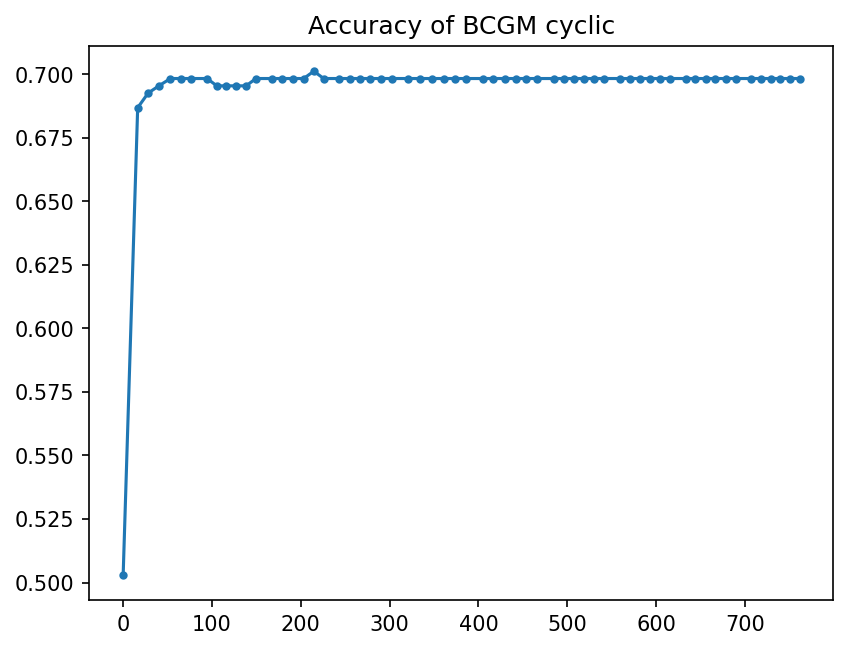

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of BCGM cyclic")
plt.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')

### Gauss-Southwell

In [ ]:
y_unlabeled_bcgd_gs = np.copy(initial_y).astype("float64")

In [ ]:
%%time
ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(labeled_y, y_unlabeled_bcgd_gs)]

max_iterations = ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(target_y) == 0:

        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(labeled_y, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 20880 - final accuracy 50.29% - loss 305055.92
10% - iter 2088 / 20880 - final accuracy 69.83% - loss 105546.57
20% - iter 4176 / 20880 - final accuracy 69.83% - loss 105546.57

Final accuracy: 69.83%
Norm gradient: 9.973435243220572e-06
Loss: 105546.56628717002

CPU times: user 182 ms, sys: 1.67 ms, total: 184 ms
Wall time: 183 ms


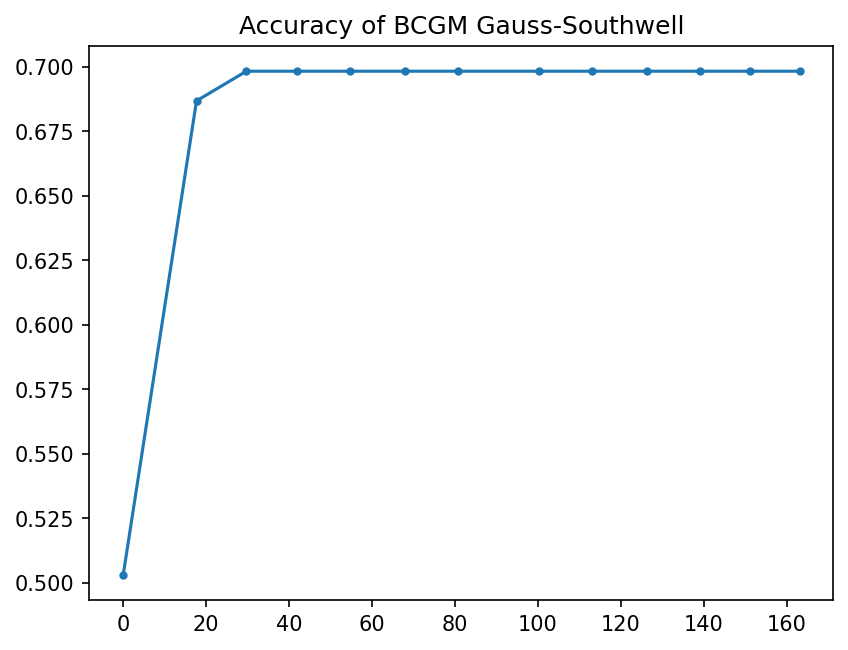

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

### Loss

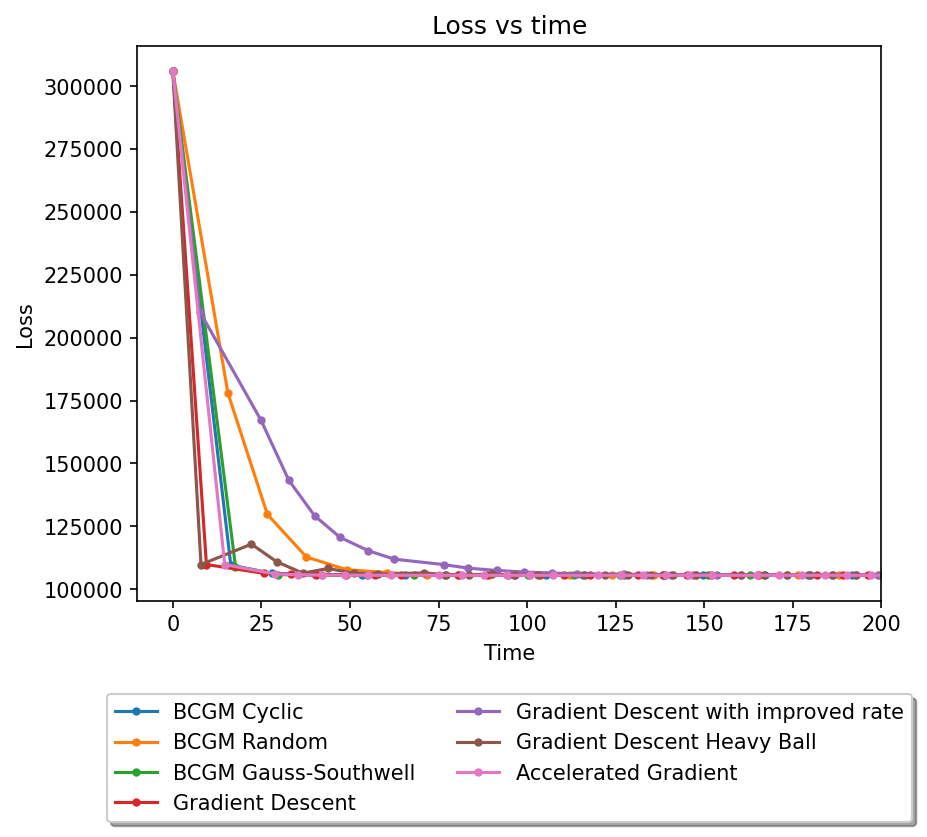

In [ ]:
plt.figure(dpi=150)
plt.plot(ticks_bcgd_cyclic , losses_bcgm_cyclic, marker='.')
plt.plot(ticks_bcgd_random , losses_bcgm_random, marker='.')
plt.plot(ticks_bcgd_gs , losses_bcgm_gs, marker='.')
plt.plot(ticks_gd , losses_gd, marker='.')
plt.plot(ticks_gd_improved , losses_gd_improved, marker='.')
plt.plot(ticks_gd_hb , losses_gd_hb, marker='.')
plt.plot(ticks_gd_accelerated , losses_gd_accelerated, marker='.')

plt.title("Loss vs time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.xlim(-10,200)
plt.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2

)